# Extreme Conditions Modeling - Contour Approach

Extreme conditions modeling consists of identifying the expected extreme (e.g. 100-year) response of some quantity of interest, such as WEC motions or mooring loads. 
Three different methods of estimating extreme conditions were adapted from [WDRT](https://github.com/WEC-Sim/WDRT): full sea state approach, contour approach, and MLER design wave. 
This noteboook presents the contour approach. 

The contour approach consists of the following steps: 
1. Sample the environmental contour for the return period of interest at N points near the maximum $H_s$.
2. For each sample $(H_{s}, T_{e})_i$ calculate the short-term (e.g. 3-hours) extreme for the quantity of interest (e.g. WEC motions or mooring tension).
3. Select the sea state with the highest short-term expected value for the quantity of interest as the design sea state, and some metric (e.g. 95th percentile) of the distribution as the extreme/design response. 

**NOTE:** Prior to running this example it is recommended to become familiar with `environmental_contours_example.ipynb` and `short_term_extremes_example.ipynb` since some code blocks are adapted from those examples and used here without the additional description. 

We start by importing the relevant modules, including `waves.contours` submodule which includes the contour function, and `loads.extreme` which inlcudes the short-term extreme functions. 

In [1]:
from mhkit.wave import resource, contours, graphics
from mhkit.loads import extreme
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
import pandas as pd
import numpy as np

## Obtain and Process NDBC Buouy Data
The first step will be obtaining the environmental data and creating the contours.
See `environmental_contours_example.ipynb` for more details and explanations of how this is being done in the following code block. 

In [2]:
parameter = "swden"
buoy_number = "46022"
ndbc_available_data = ndbc.available_data(parameter, buoy_number)

years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]

filenames = years_of_interest["filename"]
ndbc_requested_data = ndbc.request_data(parameter, filenames)

ndbc_data = {}
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

Hm0_list = []
Te_list = []

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))

# Concatenate each list of Series into a single Series
Te = pd.concat(Te_list, axis=0)
Hm0 = pd.concat(Hm0_list, axis=0)

# Name each Series and concat into a dataFrame
Te.name = 'Te'
Hm0.name = 'Hm0'
Hm0_Te = pd.concat([Hm0, Te], axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
Hm0_Te.dropna(inplace=True)
# Sort the DateTime index
Hm0_Te.sort_index(inplace=True)

Hm0_Te_clean = Hm0_Te[Hm0_Te.Hm0 < 20]

Hm0 = Hm0_Te_clean.Hm0.values
Te = Hm0_Te_clean.Te.values

dt = (Hm0_Te_clean.index[2] - Hm0_Te_clean.index[1]).seconds

## 1. Sampling
The first step is to create the environmental contour for the return period of interest, which is 100-years in this case,
using the `wave.contours.environmental_contours`. See  `environmental_contours_example.ipynb` for more details on using this function. 

Next we choose 5 sample sea states along this contour. We choose 5 equally spaced energy period values, between 15-22 seconds, to sample the contour. We then obtain the significant wave height for each sample using the `wave.contours.samples_contour` function.

In [3]:
# 100 year contour
period = 100.0
copula = contours.environmental_contours(Hm0, Te, dt, period, "PCA")
hs_contour = copula["PCA_x1"]
te_contour = copula["PCA_x2"]

# 5 samples
te_samples = np.linspace(15, 22, 5)
hs_samples = contours.samples_contour(te_samples, te_contour, hs_contour);

We now plot the contour and samples.

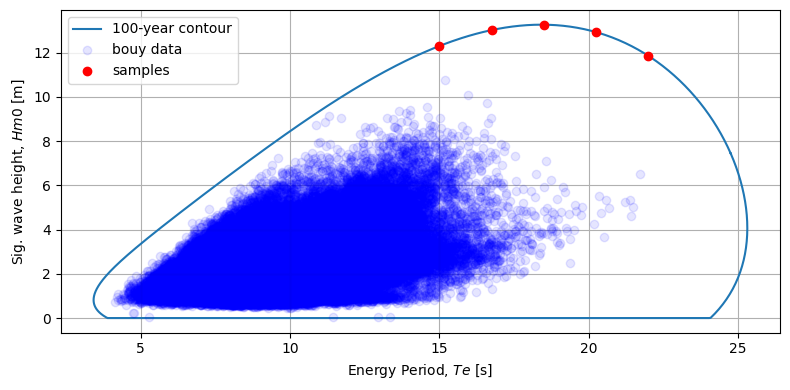

In [4]:
# plot
fig, ax = plt.subplots(figsize=(8, 4))
ax = graphics.plot_environmental_contour(
    Te,
    Hm0,
    te_contour,
    hs_contour,
    data_label="bouy data",
    contour_label="100-year contour",
    x_label="Energy Period, $Te$ [s]",
    y_label="Sig. wave height, $Hm0$ [m]",
    ax=ax,
)
ax.plot(te_samples, hs_samples, "ro", label="samples")
plt.legend()

## 2. Short-Term Extreme Distributions
Many different methods for short-term extremes were adapted from WDRT, and a summary and examples can be found in `short_term_extremes_example.ipynb`. 
The response quantity of interest is typically related to the WEC itself, e.g. maximum heave displacement, PTO extension, or load on the mooring lines. 
This requires running a simulation (e.g. WEC-Sim) for each of the 5 sampled sea states $(H_s, T_e)_i$. 
For the sake of example we will consider the wave elevation as the quantity of interest (can be thought as a proxy for heave motion in this example). 
Wave elevation time-series for a specific sea state can be created quickly without running any external software. 

**NOTE:** The majority of the for-loop below is simply creating the synthetic data (wave elevation time series). In a realistic case the variables `time` and `data` describing each time series would be obtained externally, e.g. through simulation software such as WEC-Sim or CFD. For this reason the details of creating the synthetic data are not presented here, instead assume for each sea state there is time-series data available. 

The last lines of the for-loop create the short-term extreme distribution from the time-series using the `loads.extreme.short_term_extreme` function. The short-term period will be 3-hours and we will use 1-hour "simulations" and the Weibul-tail-fitting method to estimate the 3-hour short-term extreme distributions for each of the 5 samples.

For more details see `short_term_extremes_example.ipynb` and 

> [3] Michelén Ströfer, Carlos A., and Ryan Coe. 2015. “Comparison of Methods for Estimating Short-Term Extreme Response of Wave Energy Converters.” In OCEANS 2015 - MTS/IEEE Washington, 1–6. IEEE.

In [5]:
# create the short-term extreme distribution for each sample sea state
t_st = 3.0 * 60.0 * 60.0
gamma = 3.3
t_sim = 1.0 * 60.0 * 60.0

ste_all = []
i = 0
n = len(hs_samples)
for hs, te in zip(hs_samples, te_samples):
    tp = te / (0.8255 + 0.03852 * gamma - 0.005537 * gamma**2 + 0.0003154 * gamma**3)
    i += 1
    print(f"Sea state {i}/{n}. (Hs, Te) = ({hs} m, {te} s). Tp = {tp} s")
    # time & frequency arrays
    df = 1.0 / t_sim
    T_min = tp / 10.0  # s
    f_max = 1.0 / T_min
    Nf = int(f_max / df) + 1
    time = np.linspace(0, t_sim, 2 * Nf + 1)
    f = np.linspace(0.0, f_max, Nf)
    # spectrum
    S = resource.jonswap_spectrum(f, tp, hs, gamma)
    # 1-hour elevation time-series
    data = resource.surface_elevation(S, time).values.squeeze()
    # 3-hour extreme distribution
    ste = extreme.short_term_extreme(time, data, t_st, "peaks_weibull_tail_fit")
    ste_all.append(ste)

Sea state 1/5. (Hs, Te) = (12.296107471329824 m, 15.0 s). Tp = 16.599299336182796 s
Sea state 2/5. (Hs, Te) = (13.015332686697155 m, 16.75 s). Tp = 18.535884258737457 s
Sea state 3/5. (Hs, Te) = (13.259537828803623 m, 18.5 s). Tp = 20.472469181292116 s
Sea state 4/5. (Hs, Te) = (12.922246639791062 m, 20.25 s). Tp = 22.409054103846774 s
Sea state 5/5. (Hs, Te) = (11.849171349367342 m, 22.0 s). Tp = 24.345639026401436 s


## 3. Select Design Sea State and Design Response
Finally, we will choose the sea state with the largest expected value as the design sea state. 
We will then use the 95th percentile of the short-term extreme distribution as the extreme design response. 

First we find the sampled sea state with the largest expected value, which is Hs = 12.24m, Te=15s. 

In [6]:
ev = []
for ste in ste_all:
    ev.append(ste.expect())
max_ind = np.argmax(ev)

hs_design = hs_samples[max_ind]
te_design = te_samples[max_ind]
print(f"Design sea state (Hs, Te): ({hs_design} m, {te_design} s)")

c:\Users\sterl\anaconda3\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2998: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dub = integrate.quad(fun, d, ub, **kwds)[0]


Design sea state (Hs, Te): (13.015332686697155 m, 16.75 s)


Next, we choose the 95th percentile of the short-term extreme distribution at this sea state as the extreme design response. 
This gives an extreme design elevation of 14.1 meters.

In [7]:
ste_design = ste_all[max_ind]
response_design = ste_design.ppf(0.95)

print(f"Design (extreme) reponse: {response_design} m")

Design (extreme) reponse: 14.134870969092166 m
